How to use MacOS GPU MPS
* https://www.youtube.com/watch?app=desktop&v=53PjsHUd46E&t=0s

DINOv2ForImmageClassification
* https://huggingface.co/docs/transformers/en/model_doc/dinov2 

DINOv2 Model Notebook:
* https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/DINOv2/Fine_tune_DINOv2_for_image_classification_%5Bminimal%5D.ipynb#scrollTo=OKm-nqi2eJs2

In [16]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import random
import torch.nn as nn
import torch
from PIL import Image
import torch.optim as optim
from transformers import AutoImageProcessor, Dinov2ForImageClassification
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report



### Settings for Model Training

In [8]:
rootPath = "../input/final_split_training_augmented"
trainPath= rootPath + "/train"
evalPath= rootPath + "/eval"
testPath= rootPath + "/test"

model_name = "facebook/dinov2-small-imagenet1k-1-layer"
num_classes = 4
batch_size = 32
learning_rate = 5e-5
epochs = 5
reduction_ratio = 0.2  # Define the reduction ratio for the dataset


# For MacOS MPS
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
torch.backends.mps.is_available()
print("Using device:", "mps" if torch.backends.mps.is_available() else "cpu")

# For CUDA
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print("Using device:", "cuda" if torch.cuda.is_available() else "cpu")

Using device: mps


### Data Loading 
Comment out the reduced dataset creation for full training


In [9]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

def create_reduced_dataset(full_dataset, reduction_ratio):
    total_size = len(full_dataset)
    reduced_size = int(total_size * reduction_ratio)
    indices = list(range(total_size))
    random.shuffle(indices)
    reduced_indices = indices[:reduced_size]
    reduced_dataset = Subset(full_dataset, reduced_indices)
    print(f"Reduced {full_dataset} size: {len(reduced_dataset)}")
    return reduced_dataset

trainDataset = datasets.ImageFolder(root=trainPath, transform=transform)
evalDataset = datasets.ImageFolder(root=evalPath, transform=transform)

# Commenting out the reduced dataset creation for full training
trainDataset = create_reduced_dataset(trainDataset, reduction_ratio)
evalDataset = create_reduced_dataset(evalDataset, reduction_ratio)


train_dataloader = DataLoader(trainDataset, batch_size=batch_size, shuffle=True, num_workers=num_classes)
eval_dataloader = DataLoader(evalDataset, batch_size=batch_size, shuffle=False, num_workers=num_classes)


type(trainDataset)
first_element = trainDataset[0]
print(f"Type of the first element: {type(first_element)}")
image, label = first_element
print(f"Type of the image in the first element: {type(image)}")
print(f"Is the image a PIL Image? {isinstance(image, Image.Image)}")


Reduced Dataset ImageFolder
    Number of datapoints: 8025
    Root location: ../input/final_split_training_augmented/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           ) size: 1605
Reduced Dataset ImageFolder
    Number of datapoints: 579
    Root location: ../input/final_split_training_augmented/eval
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           ) size: 115
Type of the first element: <class 'tuple'>
Type of the image in the first element: <class 'torch.Tensor'>
Is the image a PIL Image? False


In [10]:
# Number of classes in your dataset
num_classes = len(trainDataset.dataset.classes) 
print(num_classes)
print(trainDataset.dataset.classes)


4
['angry', 'happy', 'relaxed', 'sad']


### Check Distribution of Dataset

In [11]:
import os

def checkfolder(root="../input", actualFolder="final_split_training_augmented"):
    folder = os.path.join(root, actualFolder)
    if os.path.exists(folder):
        for sub in os.listdir(folder):
            print("------------")
            print(sub)
            subFolder = os.path.join(folder, sub)
            if os.path.isdir(subFolder):
                total_images_subfolder = 0
                emotion_counts = {}
                for emotion in os.listdir(subFolder):
                    subFolderEmotion = os.path.join(subFolder, emotion)
                    if os.path.isdir(subFolderEmotion):
                        count = len(os.listdir(subFolderEmotion))
                        emotion_counts[emotion] = count
                        total_images_subfolder += count

                if total_images_subfolder > 0:
                    for emotion, count in emotion_counts.items():
                        percentage = (count / total_images_subfolder) * 100
                        print(f"{emotion} : {count} - {percentage:.2f}%")
                else:
                    print(f"No images found in {subFolder}")
            else:
                print(f"{subFolder} is not a directory.")
    else:
        print(f"Folder not found: {folder}")

checkfolder()

------------
test
happy : 148 - 25.87%
sad : 138 - 24.13%
angry : 140 - 24.48%
relaxed : 146 - 25.52%
------------
train
happy : 2079 - 25.91%
sad : 1932 - 24.07%
angry : 1965 - 24.49%
relaxed : 2049 - 25.53%
------------
eval
happy : 150 - 25.91%
sad : 139 - 24.01%
angry : 142 - 24.53%
relaxed : 148 - 25.56%


### Model Training

In [12]:
image_processor = AutoImageProcessor.from_pretrained(model_name)
model = Dinov2ForImageClassification.from_pretrained(model_name, num_labels=num_classes, ignore_mismatched_sizes=True)

model.to(device)
model.train()

# Freeze all layers except the classifier
for name, param in model.named_parameters():
    if "classifier" not in name:
        param.requires_grad = False
    else:
        param.requires_grad = True

# Define the optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()


train_losses = []
train_accuracies = []
eval_losses = []
eval_accuracies = []
all_true_labels = []
all_predicted_labels = []

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")
    # batch: In each iteration of this loop, batch will contain one batch of data loaded by your train_dataloader. Since you created the train_dataloader from a torch.utils.data.Dataset (specifically a Subset of ImageFolder), each batch will typically be a list or tuple containing:
    # A tensor of images (the first element, batch[0]). -> PyTorch tensors of shape (batch_size, C, H, W) e.g. (32, 3, 224, 224) for a batch size of 32 and colour images resized to 224x224.
    # A tensor of corresponding labels (the second element, batch[1]).
    for batch in progress_bar:

        inputs = image_processor(images=list(batch[0]), return_tensors="pt", do_rescale=False).to(device)
        labels = batch[1].to(device)

        optimizer.zero_grad()
        outputs = model(**inputs).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs['pixel_values'].size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        progress_bar.set_postfix({"loss": total_loss / total_samples, "accuracy": correct_predictions / total_samples})

    epoch_loss = total_loss / total_samples
    epoch_accuracy = correct_predictions / total_samples
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    print(f"Epoch {epoch+1} Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.4f}")



    # Evaluation loop
    model.eval()
    eval_loss = 0
    eval_correct_predictions = 0
    eval_total_samples = 0
    current_epoch_true_labels = []
    current_epoch_predicted_labels = []
    with torch.no_grad():
        progress_bar_eval = tqdm(eval_dataloader, desc=f"Evaluating Epoch {epoch+1}", unit="batch")
        for batch in progress_bar_eval:
            
            inputs = image_processor(images=list(batch[0]), return_tensors="pt", do_rescale=False).to(device)
            labels = batch[1].to(device)

            outputs = model(**inputs).logits
            loss = criterion(outputs, labels)

            eval_loss += loss.item() * inputs['pixel_values'].size(0)
            _, predicted = torch.max(outputs, 1)
            eval_correct_predictions += (predicted == labels).sum().item()
            eval_total_samples += labels.size(0)

            current_epoch_true_labels.extend(labels.cpu().numpy())
            current_epoch_predicted_labels.extend(predicted.cpu().numpy())
        

            progress_bar_eval.set_postfix({"loss": eval_loss / eval_total_samples, "accuracy": eval_correct_predictions / eval_total_samples})

    eval_epoch_loss = eval_loss / eval_total_samples
    eval_epoch_accuracy = eval_correct_predictions / eval_total_samples
    eval_losses.append(eval_epoch_loss)
    eval_accuracies.append(eval_epoch_accuracy)
    print(f"Epoch {epoch+1} Evaluation Loss: {eval_epoch_loss:.4f}, Evaluation Accuracy: {eval_epoch_accuracy:.4f}")
    
    all_true_labels.extend(current_epoch_true_labels)
    all_predicted_labels.extend(current_epoch_predicted_labels)

print("Finished Fine-tuning with Reduced Dataset!") 


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-small-imagenet1k-1-layer and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/5: 100%|██████████| 51/51 [00:39<00:00,  1.30batch/s, loss=1.64, accuracy=0.274]


Epoch 1 Training Loss: 1.6391, Training Accuracy: 0.2741


Evaluating Epoch 1: 100%|██████████| 4/4 [00:23<00:00,  5.82s/batch, loss=1.67, accuracy=0.226] 


Epoch 1 Evaluation Loss: 1.6702, Evaluation Accuracy: 0.2261


Epoch 2/5: 100%|██████████| 51/51 [00:40<00:00,  1.25batch/s, loss=1.42, accuracy=0.357]


Epoch 2 Training Loss: 1.4243, Training Accuracy: 0.3570


Evaluating Epoch 2: 100%|██████████| 4/4 [00:22<00:00,  5.67s/batch, loss=1.49, accuracy=0.287]


Epoch 2 Evaluation Loss: 1.4946, Evaluation Accuracy: 0.2870


Epoch 3/5: 100%|██████████| 51/51 [00:40<00:00,  1.25batch/s, loss=1.28, accuracy=0.417]


Epoch 3 Training Loss: 1.2802, Training Accuracy: 0.4174


Evaluating Epoch 3: 100%|██████████| 4/4 [00:22<00:00,  5.74s/batch, loss=1.36, accuracy=0.357]


Epoch 3 Evaluation Loss: 1.3595, Evaluation Accuracy: 0.3565


Epoch 4/5: 100%|██████████| 51/51 [00:41<00:00,  1.23batch/s, loss=1.17, accuracy=0.49] 


Epoch 4 Training Loss: 1.1733, Training Accuracy: 0.4897


Evaluating Epoch 4: 100%|██████████| 4/4 [00:22<00:00,  5.74s/batch, loss=1.26, accuracy=0.435]


Epoch 4 Evaluation Loss: 1.2594, Evaluation Accuracy: 0.4348


Epoch 5/5: 100%|██████████| 51/51 [00:40<00:00,  1.26batch/s, loss=1.1, accuracy=0.524] 


Epoch 5 Training Loss: 1.0950, Training Accuracy: 0.5240


Evaluating Epoch 5: 100%|██████████| 4/4 [00:22<00:00,  5.68s/batch, loss=1.19, accuracy=0.443]

Epoch 5 Evaluation Loss: 1.1879, Evaluation Accuracy: 0.4435
Finished Fine-tuning with Reduced Dataset!


### Evaluation Metrics

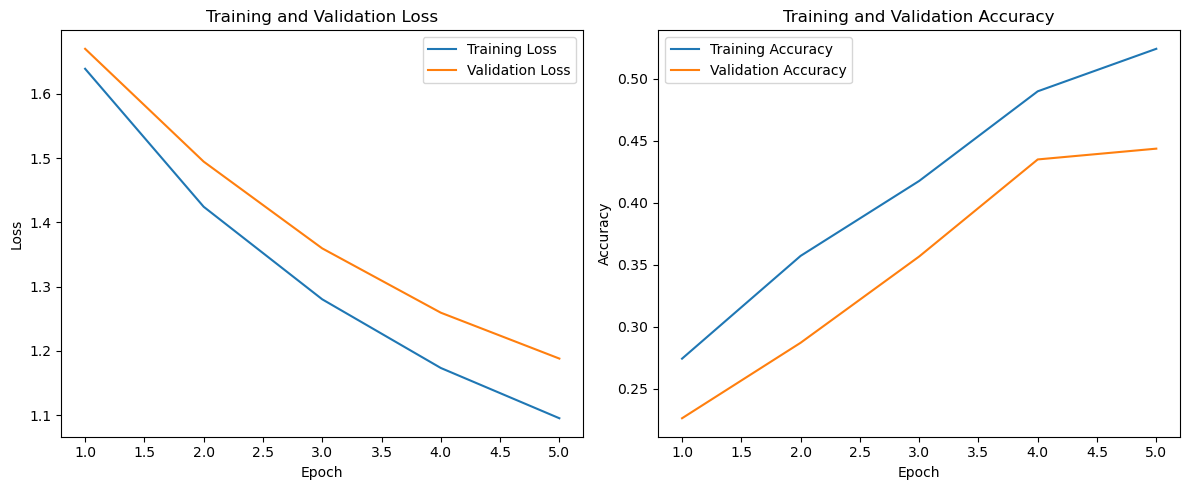


--- Final Evaluation Metrics ---
Accuracy: 0.3496
Precision: 0.3710
Recall: 0.3496
F1-Score: 0.3527

Classification Report:
               precision    recall  f1-score   support

       angry       0.40      0.31      0.35       135
       happy       0.28      0.33      0.30       125
     relaxed       0.28      0.42      0.34       125
         sad       0.46      0.34      0.39       190

    accuracy                           0.35       575
   macro avg       0.36      0.35      0.35       575
weighted avg       0.37      0.35      0.35       575



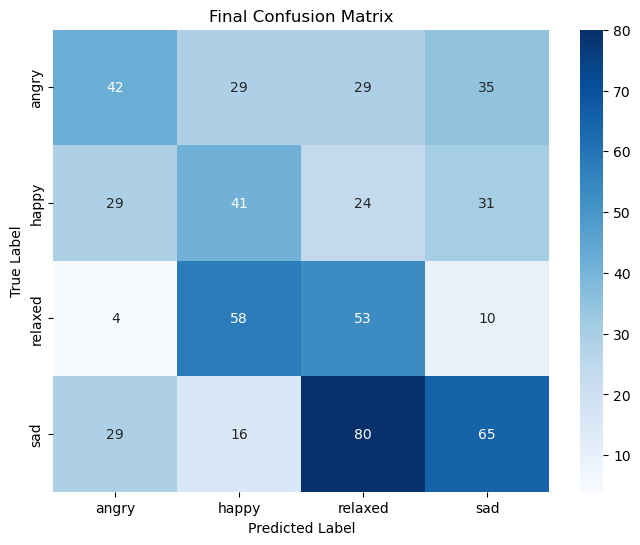

In [18]:

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), eval_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs + 1), eval_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

accuracy = accuracy_score(all_true_labels, all_predicted_labels)
precision = precision_score(all_true_labels, all_predicted_labels, average='weighted', zero_division=0)
recall = recall_score(all_true_labels, all_predicted_labels, average='weighted', zero_division=0)
f1 = f1_score(all_true_labels, all_predicted_labels, average='weighted', zero_division=0)
cm = confusion_matrix(all_true_labels, all_predicted_labels)

print("\n--- Final Evaluation Metrics ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")



class_names = evalDataset.dataset.classes
report = classification_report(all_true_labels, all_predicted_labels, target_names=class_names, zero_division=0)
print("\nClassification Report:\n", report)


# Plot Confusion Matrix
class_names = evalDataset.dataset.classes
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Final Confusion Matrix')
plt.show()

### Sampling 4 Images

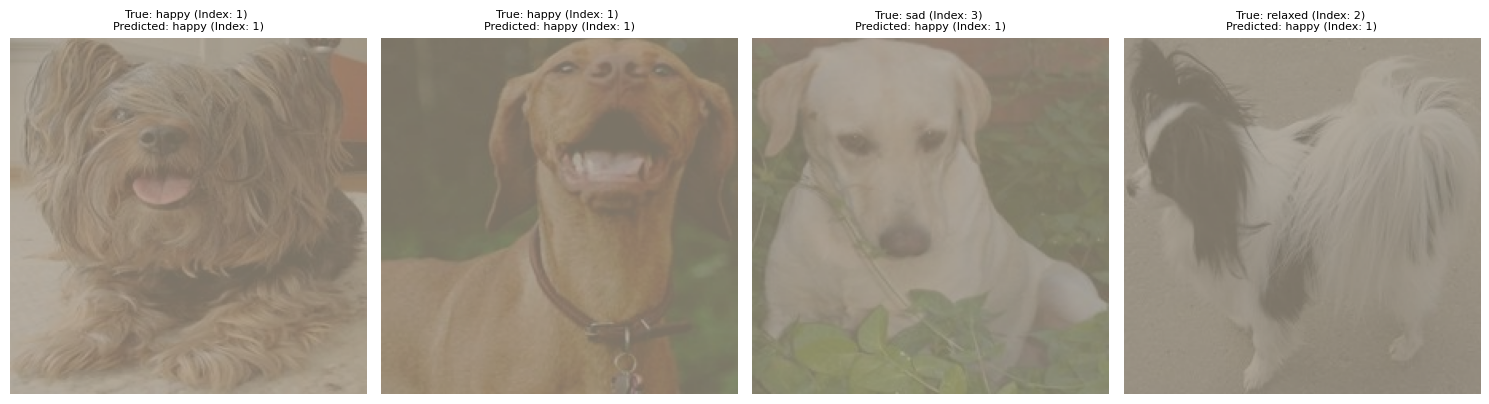

In [19]:
import random

# Assuming your model is trained and in evaluation mode (model.eval())
# Assuming you have your eval_dataloader and eval_dataset

model.eval()

def visualize_random_eval_samples(dataloader, dataset, model, image_processor, device, num_samples=4):
    # Get random indices within the dataset
    random_indices = random.sample(range(len(dataset)), num_samples)

    # Create subplots for visualization
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))  # Adjust figsize as needed

    for i, random_index in enumerate(random_indices):
        # Get the sample at that index
        sample = dataset[random_index]
        image_tensor = sample[0].unsqueeze(0).to(device)  # Add batch dimension and move to device
        true_label_tensor = torch.tensor([sample[1]]).to(device)  # Create a batch label

        # Perform inference
        with torch.no_grad():
            inputs = image_processor(images=[transforms.ToPILImage()(image_tensor.cpu().squeeze(0))], return_tensors="pt", do_rescale=False).to(device)
            outputs = model(**inputs).logits
            probabilities = torch.softmax(outputs, dim=-1)
            _, predicted_label_tensor = torch.max(probabilities, dim=-1)

        first_image_tensor = image_tensor.squeeze(0)
        first_true_label = true_label_tensor.item()
        first_predicted_label = predicted_label_tensor.item()

        class_names = dataset.dataset.classes
        first_true_class_name = class_names[first_true_label]
        first_predicted_class_name = class_names[first_predicted_label]

        mean = torch.tensor(image_processor.image_mean).cpu()
        std = torch.tensor(image_processor.image_std).cpu()
        unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())
        img_unnormalized = unnormalize(first_image_tensor.cpu())
        img_pil = transforms.ToPILImage()(img_unnormalized)

        # Display the image in the subplot
        axes[i].imshow(img_pil)
        axes[i].set_title(f"True: {first_true_class_name} (Index: {dataset.dataset.class_to_idx[first_true_class_name]}) \nPredicted: {first_predicted_class_name} (Index: {dataset.dataset.class_to_idx[first_predicted_class_name]})", fontsize=8)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()



# Call the function
visualize_random_eval_samples(eval_dataloader, evalDataset, model, image_processor, device, num_samples=4)